# Example of generation on MNIST

This note book shows the difference in terms of generation quality while using different models

- Vanilla VAE with $\mathcal{N}(0, I)$ prior + prior based generation
- VAE with VAMP prior + prior based generation
- RHVAE with $\mathcal{N}(0, I)$ prior + prior based generation
- RHVAE + Riemmanian random walk (Ours)
- RHVAE + manifold sampling (Ours)


Note: You can try with other datasets and trained models.
Loaders for EMNIST, Fashion and the shape data are available in `../training_data` folder.
Trained models on those data sets are available in `../trained_model` folder.

All you have to do is amend the paths used below (and shape pour synthetic data since images or 50x50)

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import matplotlib
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import torch
import numpy as np
from models.vae import VAE, HVAE, RHVAE
from models.config import Model_config, Train_config, ArgsConfig
from vae_vampprior.models.VAE import VAE as VAE_Vamp
from models.generation import hmc_manifold_sampling, random_walk_batch
from utils import create_metric, create_inverse_metric

device = "cpu"
seed = 8
samples_colors = ['blue', 'skyblue']

# MNIST

## Training Samples 

In [55]:
path_loader = '../training_data/train_MNIST'
raw_data = torch.load(path_loader, map_location=torch.device('cpu'))['data']

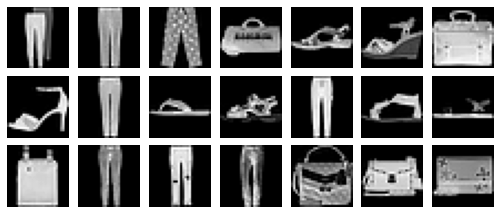

In [56]:
fig, axes  = plt.subplots(nrows=3, ncols=7, figsize=(7, 3))
img_no = 0
for i in range(3):
    for j in range(7):
        axes[i][j].imshow(raw_data[img_no], cmap='gray')
        axes[i][j].axis('off')
        img_no+=1
fig.tight_layout(pad=0.8)

## VAE - Gaussian prior

In [57]:
path_to_model = "../trained_models/VAE_train_MNIST_ldim_10/VAE_train_MNIST.model"
device = 'cpu'
checkpoint = torch.load(path_to_model, map_location=torch.device(device))

args = checkpoint['args']
args.device = device
vae_rec = VAE(args).to(device)
vae_rec.load_state_dict(
    checkpoint["model_state_dict"])

<All keys matched successfully>

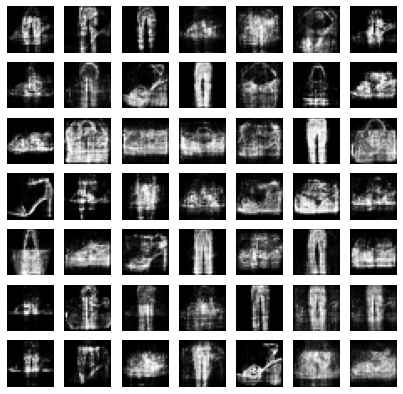

In [58]:
torch.manual_seed(1)
n_im = 50
im_shape = 28
z = torch.randn(n_im, 10).to(device)
m = vae_rec

recon_x = m.sample_img(z=z).detach().cpu().numpy().reshape(n_im, im_shape, im_shape)

fig, axes  = plt.subplots(nrows=int(n_im**0.5), ncols=int(n_im**0.5), figsize=(int(n_im**0.5), int(n_im**0.5)))
img_no = 0
for i in range(int(int(n_im**0.5))):
    for j in range(int(n_im**0.5)):
        axes[i][j].imshow(recon_x[img_no], cmap='gray')
        axes[i][j].axis('off')
        img_no+=1

## VAE - Vamp prior 

In [29]:
path_to_model = "../trained_models/peers/VAMP_train_MNIST_ldim_10"
checkpoint = torch.load(path_to_model, map_location=device)
checkpoint['args_model'].cuda = False
vamp_rec = VAE_Vamp(checkpoint['args_model'])
vamp_rec.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

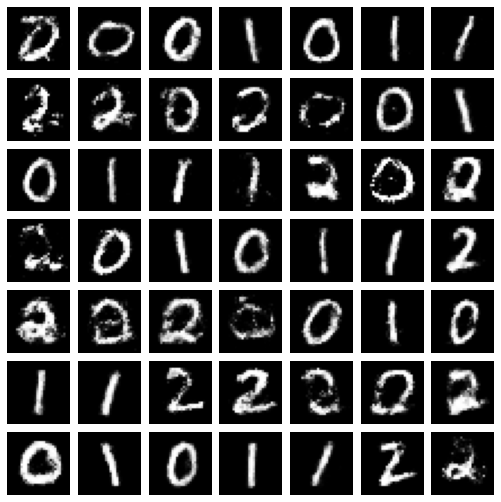

In [30]:
torch.manual_seed(seed)
n_im = 50
generated_data = []
for i in range(int(n_im / 10)):
    recon_x, z = vamp_rec.generate_x(N=n_im)
    generated_data.append(recon_x)

recon_x = torch.cat(generated_data)

fig, axes  = plt.subplots(nrows=int(n_im**0.5), ncols=int(n_im**0.5), figsize=(int(n_im**0.5), int(n_im**0.5)))
img_no = 0
for i in range(int(int(n_im**0.5))):
    for j in range(int(n_im**0.5)):
        axes[i][j].imshow(recon_x[img_no].detach().cpu().reshape(28, 28), cmap='gray')
        axes[i][j].axis('off')
        img_no+=1
fig.tight_layout(pad=0.8)

## RHVAE - Gaussian prior

In [31]:
path_to_model = "../trained_models/RHVAE_train_MNIST_ldim_10_nlf_3_epslf_0.01_T_1.5_lbd_0.001/RHVAE_train_MNIST.model"
checkpoint = torch.load(path_to_model, map_location=device)

args = checkpoint['args']
args.device = device
rhvae_rec = RHVAE(args)
rhvae_rec.load_state_dict(
    checkpoint["model_state_dict"])
rhvae_rec.M_tens = checkpoint['M']
rhvae_rec.centroids_tens = checkpoint["centroids"]
rhvae_rec.G = create_metric(rhvae_rec)
rhvae_rec.G_inv = create_inverse_metric(rhvae_rec)

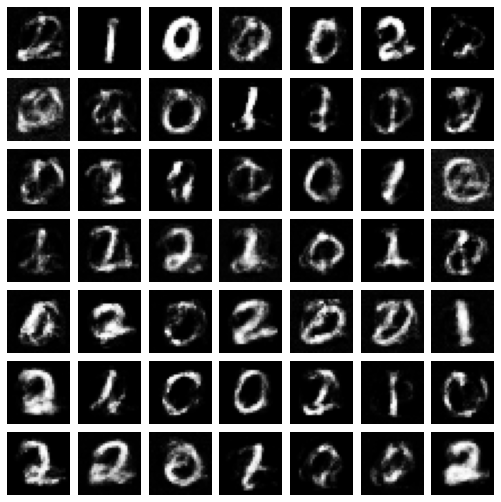

In [33]:
torch.manual_seed(88)
n_im = 50
im_shape = 28
z = torch.randn(n_im, 10)
m = rhvae_rec
recon_x = m.sample_img(z=z).detach().cpu().numpy().reshape(n_im, im_shape, im_shape)

fig, axes  = plt.subplots(nrows=int(n_im**0.5), ncols=int(n_im**0.5), figsize=(int(n_im**0.5), int(n_im**0.5)))
img_no = 0
for i in range(int(int(n_im**0.5))):
    for j in range(int(n_im**0.5)):
        axes[i][j].imshow(recon_x[img_no], cmap='gray')
        axes[i][j].axis('off')
        img_no+=1
fig.tight_layout(pad=0.8)

## Riemannian Random Walk

In [51]:
m = rhvae_rec

torch.manual_seed(8)
generated_data = []

for i in range(1):
    samples = random_walk_batch(
    model=m,
    latent_dim=10,
    n_steps=100,
    n_samples=50,
    verbose=True
    )

    generated_data.append(samples)

samples = torch.cat(generated_data).detach()

/home/clement/Documents/these/implem/DALI_code/clean_code/models/generation.py:206: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  )


Iteration 0 / 100


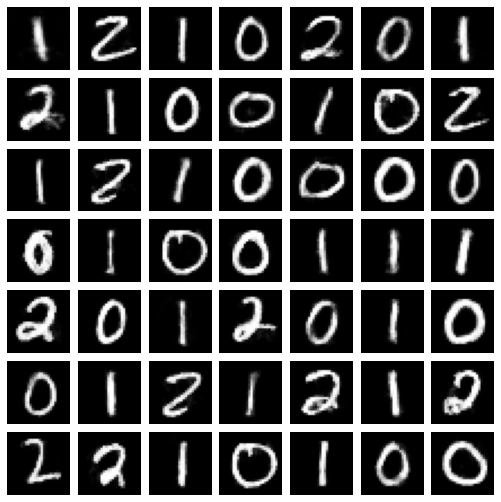

In [52]:
n_im = 50
im_shape = 28
m = rhvae_rec
recon_x = m.sample_img(z=samples).detach().cpu().numpy().reshape(n_im, im_shape, im_shape)

fig, axes  = plt.subplots(nrows=int(n_im**0.5), ncols=int(n_im**0.5), figsize=(int(n_im**0.5), int(n_im**0.5)))
img_no = 0
for i in range(int(int(n_im**0.5))):
    for j in range(int(n_im**0.5)):
        axes[i][j].imshow(recon_x[img_no], cmap='gray')
        axes[i][j].axis('off')
        img_no+=1
fig.tight_layout(pad=0.8)

## Manifold Sampling
This method approximate the first one under certain conditions and is more robust to use in practice 

In [53]:
m= rhvae_rec

torch.manual_seed(88)
generated_data = []

for i in range(1):
    samples = hmc_manifold_sampling(
    model=m,
    latent_dim=10,
    n_samples=50,
    step_nbr=100,
    n_lf=15,
    eps_lf=0.01,
    verbose=True
    )

    generated_data.append(samples)

samples = torch.cat(generated_data).detach()

Iteration 0 / 100


/home/clement/Documents/these/implem/DALI_code/clean_code/models/generation.py:292: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha = torch.exp(-H) / (torch.exp(-H0))


Iteration 50 / 100


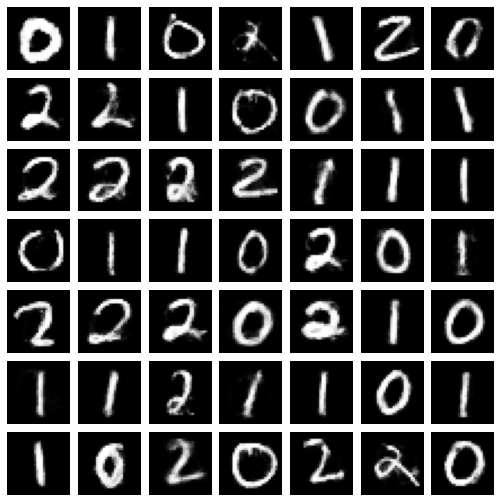

In [54]:
n_im = 50
im_shape = 28
m = rhvae_rec
recon_x = m.sample_img(z=samples).detach().cpu().numpy().reshape(n_im, im_shape, im_shape)

fig, axes  = plt.subplots(nrows=int(n_im**0.5), ncols=int(n_im**0.5), figsize=(int(n_im**0.5), int(n_im**0.5)))
img_no = 0
for i in range(int(int(n_im**0.5))):
    for j in range(int(n_im**0.5)):
        axes[i][j].imshow(recon_x[img_no], cmap='gray')
        axes[i][j].axis('off')
        img_no+=1
fig.tight_layout(pad=0.8)

# Trying with other data sets and models
As stated abose you can try with other data sets used in the paper by only changing the paths.

In [59]:
# For Fashion
path_loader = '../training_data/train_Fashion'
raw_data = torch.load(path_loader, map_location=torch.device('cpu'))['data']

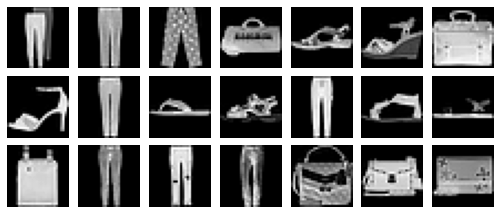

In [60]:
fig, axes  = plt.subplots(nrows=3, ncols=7, figsize=(7, 3))
img_no = 0
for i in range(3):
    for j in range(7):
        axes[i][j].imshow(raw_data[img_no], cmap='gray')
        axes[i][j].axis('off')
        img_no+=1
fig.tight_layout(pad=0.8)

In [64]:
path_to_model = "../trained_models/RHVAE_train_Fashion_ldim_10_nlf_3_epslf_0.01_T_1.5_lbd_0.001/RHVAE_train_Fashion.model"
checkpoint = torch.load(path_to_model, map_location=device)

args = checkpoint['args']
args.device = device
rhvae_rec = RHVAE(args)
rhvae_rec.load_state_dict(
    checkpoint["model_state_dict"])
rhvae_rec.M_tens = checkpoint['M']
rhvae_rec.centroids_tens = checkpoint["centroids"]
rhvae_rec.G = create_metric(rhvae_rec)
rhvae_rec.G_inv = create_inverse_metric(rhvae_rec)

In [65]:
m= rhvae_rec

torch.manual_seed(88)
generated_data = []

for i in range(1):
    samples = hmc_manifold_sampling(
    model=m,
    latent_dim=10,
    n_samples=50,
    step_nbr=100,
    n_lf=15,
    eps_lf=0.01,
    verbose=True
    )

    generated_data.append(samples)

samples = torch.cat(generated_data).detach()

Iteration 0 / 100
Iteration 50 / 100


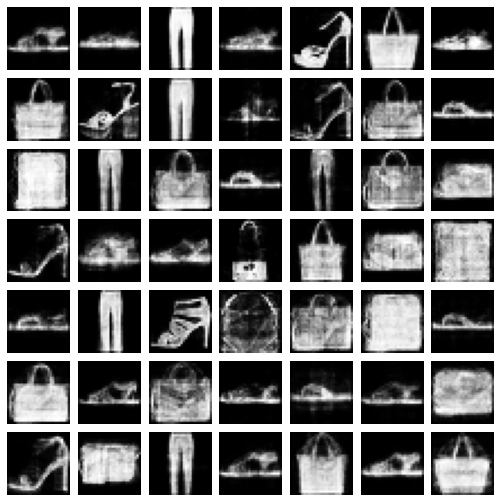

In [66]:
n_im = 50
im_shape = 28
m = rhvae_rec
recon_x = m.sample_img(z=samples).detach().cpu().numpy().reshape(n_im, im_shape, im_shape)

fig, axes  = plt.subplots(nrows=int(n_im**0.5), ncols=int(n_im**0.5), figsize=(int(n_im**0.5), int(n_im**0.5)))
img_no = 0
for i in range(int(int(n_im**0.5))):
    for j in range(int(n_im**0.5)):
        axes[i][j].imshow(recon_x[img_no], cmap='gray')
        axes[i][j].axis('off')
        img_no+=1
fig.tight_layout(pad=0.8)

In [42]:
path_to_model = "../trained_models/RHVAE_train_Shapes_ldim_2_nlf_3_epslf_0.01_T_0.8_lbd_0.001/RHVAE_train_Shapes.model"
checkpoint = torch.load(path_to_model, map_location=device)

args = checkpoint['args']
args.device = device
rhvae_rec = RHVAE(args)
rhvae_rec.load_state_dict(
    checkpoint["model_state_dict"])
rhvae_rec.M_tens = checkpoint['M']
rhvae_rec.centroids_tens = checkpoint["centroids"]
rhvae_rec.G = create_metric(rhvae_rec)
rhvae_rec.G_inv = create_inverse_metric(rhvae_rec)

Parameter containing:
tensor([0.8000]) Parameter containing:
tensor([0.0010])


In [55]:
m= rhvae_rec

torch.manual_seed(88)
generated_data = []

for i in range(1):
    samples = hmc_manifold_sampling(
    model=m,
    latent_dim=2, # Amend latent dim since we used a model using a latent dim of 2
    n_samples=50,
    step_nbr=100,
    n_lf=5,
    eps_lf=0.01,
    verbose=True
    )

    generated_data.append(samples)

samples = torch.cat(generated_data).detach()

Iteration 0 / 100
Iteration 50 / 100


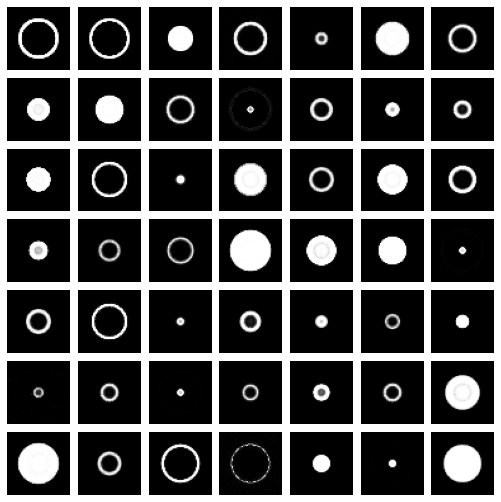

In [56]:
n_im = 50
im_shape = 50 # For shape data amend the im_shape
m = rhvae_rec
recon_x = m.sample_img(z=samples).detach().cpu().numpy().reshape(n_im, im_shape, im_shape)

fig, axes  = plt.subplots(nrows=int(n_im**0.5), ncols=int(n_im**0.5), figsize=(int(n_im**0.5), int(n_im**0.5)))
img_no = 0
for i in range(int(int(n_im**0.5))):
    for j in range(int(n_im**0.5)):
        axes[i][j].imshow(recon_x[img_no], cmap='gray')
        axes[i][j].axis('off')
        img_no+=1
fig.tight_layout(pad=0.8)

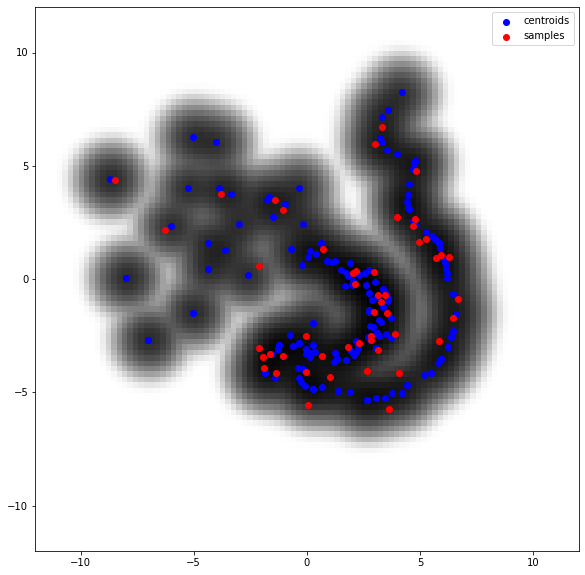

In [57]:
# You can also print the latent space when dealing with 2D latent spaces
plt.figure(figsize=(10, 10))
lim=12

X = torch.linspace(lim, -lim, 100).type(torch.float)
Y = torch.linspace(-lim, lim, 100).type(torch.float)
mesh = torch.tensor([[y, x] for x in X for y in Y])

magn = (torch.sqrt(torch.det(m.G(mesh))).detach().cpu().numpy().reshape(100, 100))
im = plt.imshow(np.log(magn), cmap='gray', extent=[-lim, lim, -lim, lim])
plt.scatter(m.centroids_tens[:, 0], m.centroids_tens[:, 1], c='b', label='centroids')
plt.scatter(samples[:, 0].detach().cpu(), samples[:, 1].detach().cpu(), c='r', label='samples')
plt.legend()